In [0]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Create a SparkSession
spark = SparkSession.builder.appName("PandasVsSpark").getOrCreate()


In [0]:
print("np.__version__", np.__version__)
print("pd.__version__", pd.__version__)
print("spark.version", spark.version)

np.__version__ 1.26.4
pd.__version__ 1.5.3
spark.version 3.5.2


In [0]:
# Cell 2: Define testing parameters and initialize results lists

# For pandas, we test for 1K, 10K, and 100K rows.
pandas_rows = [1000, 10000, 100000, 1000000, 10000000]

# For spark, we test for the same as pandas plus 1M and 10M rows.
spark_rows = [1000, 10000, 100000, 1000000, 10000000, 100000000]

# Lists to store the timing results as dictionaries: {"rows": n, "time_taken": elapsed}
pandas_times = []
spark_times = []


In [0]:
# Cell 3: Test Pandas DataFrame operations

for n in pandas_rows:
    # Create a random pandas DataFrame with two columns: num1 (integer) and num2 (float)
    df = pd.DataFrame({
        "num1": np.random.randint(1, 100, size=n),
        "num2": np.random.random(size=n) * 100
    })
    
    # Time the operation of creating a new column 'sum' as the addition of 'num1' and 'num2'
    start = timeit.default_timer()
    df['sum'] = df['num1'] + df['num2']
    elapsed = timeit.default_timer() - start
    
    # Append result as a dict with the number of rows and time taken
    pandas_times.append({"rows": n, "time_taken": elapsed})
    print(f"Pandas: Processed {n} rows in {elapsed:.6f} seconds")


Pandas: Processed 1000 rows in 0.001553 seconds
Pandas: Processed 10000 rows in 0.001115 seconds
Pandas: Processed 100000 rows in 0.001335 seconds
Pandas: Processed 1000000 rows in 0.010435 seconds
Pandas: Processed 10000000 rows in 0.063022 seconds


In [0]:
# Cell 4: Test PySpark DataFrame operations

for n in spark_rows:
    # For small datasets, create the data using a list comprehension; for large ones, generate directly from an RDD.
    if n <= 10000000:
        data = [(int(np.random.randint(1, 100)), float(np.random.random() * 100)) for _ in range(n)]
        df = spark.createDataFrame(data, schema=["num1", "num2"])
    else:
        # For large numbers, generate the DataFrame directly using an RDD.
        # This avoids collecting data into the driver.
        df = spark.sparkContext.parallelize(range(n)) \
              .map(lambda x: (int(np.random.randint(1, 100)), float(np.random.random() * 100))) \
              .toDF(["num1", "num2"])
    
    # Time the addition of the 'sum' column
    start = timeit.default_timer()
    df = df.withColumn("sum", F.col("num1") + F.col("num2"))
    # Force evaluation with an action (count) so that the computation takes place.
    _ = df.count()
    elapsed = timeit.default_timer() - start
    
    spark_times.append({"rows": n, "time_taken": elapsed})
    print(f"Spark: Processed {n} rows in {elapsed:.6f} seconds")


Spark: Processed 1000 rows in 1.150879 seconds
Spark: Processed 10000 rows in 0.265726 seconds
Spark: Processed 100000 rows in 0.266746 seconds
Spark: Processed 1000000 rows in 0.673534 seconds
Spark: Processed 10000000 rows in 3.382112 seconds
Spark: Processed 100000000 rows in 185.322684 seconds


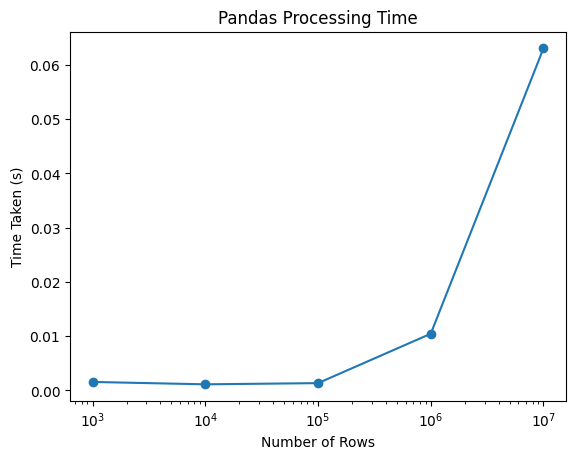

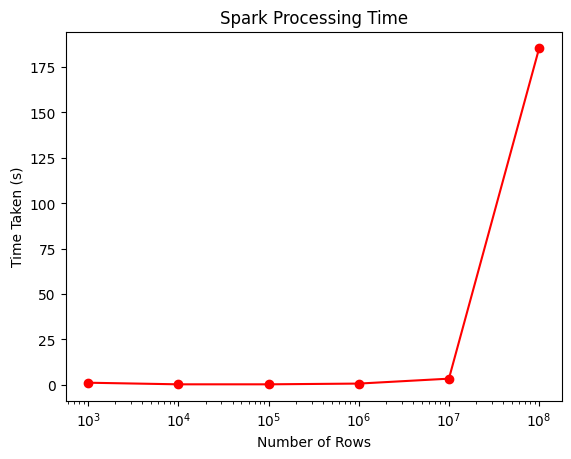

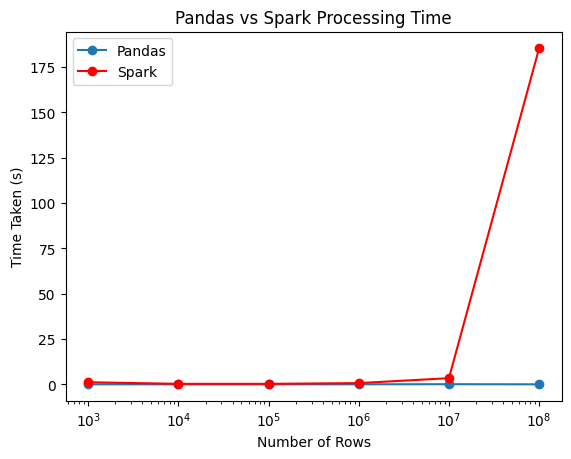

Pandas times: [{'rows': 1000, 'time_taken': 0.0015527640000527754}, {'rows': 10000, 'time_taken': 0.0011150450000059209}, {'rows': 100000, 'time_taken': 0.0013353550000374526}, {'rows': 1000000, 'time_taken': 0.010434729000053267}, {'rows': 10000000, 'time_taken': 0.06302189400003044}]
Spark times: [{'rows': 1000, 'time_taken': 1.15087855999991}, {'rows': 10000, 'time_taken': 0.2657255530000384}, {'rows': 100000, 'time_taken': 0.2667456570000013}, {'rows': 1000000, 'time_taken': 0.6735339930000919}, {'rows': 10000000, 'time_taken': 3.3821117960001175}, {'rows': 100000000, 'time_taken': 185.32268387199997}]


In [0]:
# Cell 5: Plot and save performance results

# Create dictionaries mapping row counts to time taken for easier lookup.
pandas_dict = {d["rows"]: d["time_taken"] for d in pandas_times}
spark_dict = {d["rows"]: d["time_taken"] for d in spark_times}

# ----------------------------
# Plot for Pandas performance
x_pandas = sorted(pandas_dict.keys())
y_pandas = [pandas_dict[x] for x in x_pandas]

plt.figure()
plt.plot(x_pandas, y_pandas, marker='o')
plt.xscale('log')
plt.xlabel("Number of Rows")
plt.ylabel("Time Taken (s)")
plt.title("Pandas Processing Time")
plt.savefig("pandas_times.png")
plt.show()

# ----------------------------
# Plot for Spark performance
x_spark = sorted(spark_dict.keys())
y_spark = [spark_dict[x] for x in x_spark]

plt.figure()
plt.plot(x_spark, y_spark, marker='o', color='red')
plt.xscale('log')
plt.xlabel("Number of Rows")
plt.ylabel("Time Taken (s)")
plt.title("Spark Processing Time")
plt.savefig("spark_times.png")
plt.show()

# ----------------------------
# Combined Plot: For row counts that pandas did not test (1M and 10M), assign 0 time for pandas.
combined_x = sorted(spark_dict.keys())  # using spark_rows as the x-axis
combined_y_pandas = [pandas_dict.get(x, 0) for x in combined_x]
combined_y_spark = [spark_dict.get(x, 0) for x in combined_x]

plt.figure()
plt.plot(combined_x, combined_y_pandas, marker='o', label="Pandas")
plt.plot(combined_x, combined_y_spark, marker='o', label="Spark", color='red')
plt.xscale('log')
plt.xlabel("Number of Rows")
plt.ylabel("Time Taken (s)")
plt.title("Pandas vs Spark Processing Time")
plt.legend()
plt.savefig("combined_times.png")
plt.show()

# Optionally, print out the lists of dictionaries showing points -> time taken
print("Pandas times:", pandas_times)
print("Spark times:", spark_times)
